# Description 

This notebook demonstrates how to conduct drift detection using CapyMOA. Then test different drift detectors and evaluating detectors based on known drift location. In addition, we compare the functionalities with River. 

# Imports

In [2]:
# CapyMoa
import capymoa.drift.detectors as detectors
from capymoa.drift.detectors import ADWIN
from capymoa.drift.eval_detector import EvaluateDetector
from capymoa.drift.detectors import ABCD

# River
from river import drift

# Miscellaneous for tracking
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


# CapyMOA

Here we simulate a data stream with a concept drift and evaluates how well various drift detection algorithms from the CapyMOA library can detect changes. Initially, the stream contains binary values (0 or 1), followed by a shift to values ranging from 6 to 11 at instance 999. Each detector from CapyMOA's available list is applied to the stream, and the number of times each detects a drift is recorded. The final output is a summary of drift detections per detector, useful for comparative analysis of their sensitivity and reactivity to distributional changes.

In [3]:
# Create random data to mimic a data stream
data_stream = np.random.randint(2, size=2000)
# Introduce different distribution on a given range
for i in range(999, 2000):
    data_stream[i] = np.random.randint(6, high=12)

# Get all the detectors available in CapyMOA
all_detectors = detectors.__all__

n_detections = {k: 0 for k in all_detectors}
# Iterate through detectors 
for detector_name in all_detectors:
    # Create an instance of the detector
    detector = getattr(detectors, detector_name)()
    
    #Iterate through the data stream 
    for i in range(2000):
        detector.add_element(float(data_stream[i]))
        # If the detector detected a drift add it to number of detections
        if detector.detected_change():
            n_detections[detector_name] += 1

print(pd.Series(n_detections))

ADWIN                       2
CUSUM                       2
DDM                         2
EWMAChart                   2
GeometricMovingAverage      1
HDDMAverage               140
HDDMWeighted               88
PageHinkley                 1
RDDM                        3
SEED                        3
STEPD                       1
ABCD                        1
dtype: int64


Now we focus on the ADWIN (ADaptive WINdowing) drift detection algorithm to monitor a synthetic data stream for concept drift. ADWIN dynamically adjusts a sliding window over the stream and triggers a drift when the distribution within the window significantly changes. The stream is composed of binary values at first, followed by a sudden change to a different value range, simulating drift. Finally, we provide summaries of both drift and warning detection points.

In [4]:
# Initialize the ADWIN detector with a small delta for higher sensitivity
detector = ADWIN(delta=0.001)

# Loop over the synthetic data stream of 2000 instances
for i in range(2000):
    detector.add_element(data_stream[i])
    if detector.detected_change():
        print(
            "Change detected in data: " + str(data_stream[i]) + " - at index: " + str(i)
        )

# Detection indices
print("Summary of detections' index: ", detector.detection_index)

# Warning indices
print("Summary of warning detections' index: ", detector.warning_index)

Change detected in data: 9 - at index: 1023
Change detected in data: 9 - at index: 1119
Summary of detections' index:  [1024, 1120]
Summary of warning detections' index:  []


Assuming the drift locations are known, you can evaluate detectors using EvaluateDetector class

This class takes a parameter called max_delay, which is the maximum number of instances for which we consider a detector to have detected a change. After max_delay instances, we assume that the change is obvious and have been missed by the detector.

In [5]:
eval = EvaluateDetector(max_delay=200)
trues = np.array([1000])
preds = detector.detection_index

eval.calc_performance(preds, trues)

mean_time_to_detect           24.0
missed_detection_ratio         0.0
mean_time_btw_false_alarms     NaN
no_alarms_per_episode          0.0
dtype: float64

## Multivariate Drift Detection

CapyMOA supports multivariate drift detection, unlike River. Specifically, it includes the ABCD (Adaptive Bernstein Change Detector), which is designed to handle both univariate and multivariate data streams. This allows for the detection of complex changes in the joint distribution of multiple features, which univariate detectors might miss. We demonstrate the use of the ABCD (Autoencoder-Based Change Detection) method for identifying concept drift in a multidimensional stream. It applies a PCA reconstruction loss strategy, where changes in the input distribution lead to higher reconstruction errors, indicating a drift. The reconstruction loss is tracked and plotted to visually identify drift patterns.

A 2-dimensional stream
Change detected at index: 3061


Text(0, 0.5, 'Reconstruction loss')

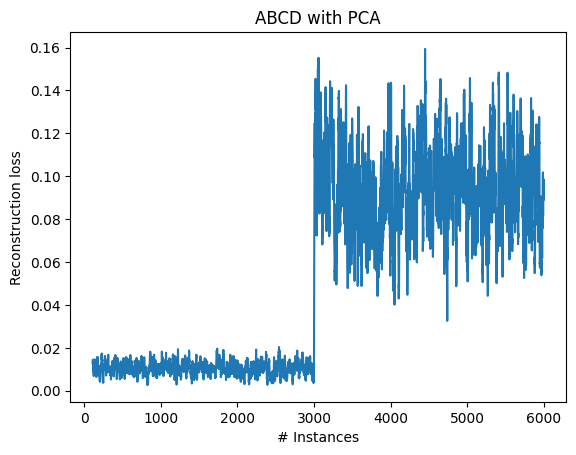

In [6]:
# Initialize ABCD with PCA as the reconstruction model
detector = ABCD(model_id="pca")

# Create a synthetic data stream where the distribution shifts in the middle
# First half: values between 0 and 0.5; Second half: values between 0.5 and 1.0
stream_change = np.hstack(
    [np.random.uniform(0, 0.5, 3000), np.random.uniform(0.5, 1.0, 3000)]
)

# Create a control stream with no distributional shift for comparison
stream_nochange = np.random.uniform(0, 1.0, len(stream_change))

# Stack both streams into a 2D structure: one column with drift, the other without
stream = np.vstack([stream_change, stream_nochange]).T
print(f"A {stream.shape[-1]}-dimensional stream")

i = 0
loss_values = []

# Loop over the data stream
while i < len(stream):
    instance = stream[i]
    i += 1
    detector.add_element(instance)
    loss_values.append(detector.loss())
    if detector.detected_change():
        print("Change detected at index: " + str(i))

plt.plot(pd.Series(loss_values).rolling(10).mean())
plt.title("ABCD with PCA")
plt.xlabel("# Instances")
plt.ylabel("Reconstruction loss")

River does not currently provide built-in support for multivariate drift detection, which involves analyzing changes in the joint distribution of multiple features simultaneously. 

# River

We try to apply multiple drift detection algorithms implemented by River (ADWIN, Page-Hinkley, and KSWIN) on a the same data stream where a distributional change is introduced halfway through. 

In [7]:
# Get all the detectors available in River
all_detectors = {
    'ADWIN': drift.ADWIN(),
    'PageHinkley': drift.PageHinkley(),
    'Kolmogorov-Smirnov Windowing': drift.KSWIN(alpha=0.0001, seed=42),
}

# Create random data to mimic a data stream
data_stream = np.random.randint(2, size=2000)
# Introduce different distribution on a given range
for i in range(999, 2000):
    data_stream[i] = np.random.randint(6, high=12)

n_detections = {k: 0 for k in all_detectors}
# Iterate through detectors 
for detector_name, detector in all_detectors.items():
    # Iterate through data stream 
    for i in range(2000):
        detector.update(float(data_stream[i]))
        # If the detector detected a drift add it to number of detections
        if detector.drift_detected:
            print(detector_name, f" detected at index: {i}")
            n_detections[detector_name] += 1

print('---------------------')
print(pd.Series(n_detections))


ADWIN  detected at index: 1023
PageHinkley  detected at index: 1004
PageHinkley  detected at index: 1335
PageHinkley  detected at index: 1647
Kolmogorov-Smirnov Windowing  detected at index: 1015
---------------------
ADWIN                           1
PageHinkley                     3
Kolmogorov-Smirnov Windowing    1
dtype: int64


Finally, we evaluate five binary drift detection algorithms from River: DDM, EDDM, FHDDM, HDDM_A, and HDDM_W. They’re statistical tests on binary inputs, usually modeling error rates over time.

In [8]:
# Get all the detectors available in River
all_detectors = {
    'Drift Detection Method': drift.binary.DDM(),
    'Early Drift Detection Method': drift.binary.EDDM(alpha=0.8, beta=0.75),
    'Fast Hoeffding Drift Detection Method': drift.binary.FHDDM(short_window_size = 20),
    'Hoeffding Bound Moving Average': drift.binary.HDDM_A(),
    'Hoeffding Bound Weighted Average': drift.binary.HDDM_W()
}

# Create random data to mimic a data stream
rng = random.Random(42)
data_stream = rng.choices([0, 1], k=1000)
data_stream = data_stream + rng.choices([0, 1], k=1000, weights=[0.3, 0.7])

n_detections = {k: {'detections': 0, 'warnings': 0} for k in all_detectors}
for detector_name, detector in all_detectors.items():
    print(detector_name)
    # Iterate through data stream 
    for i, x in enumerate(data_stream):
        detector.update(x)
        if detector.drift_detected:
            print(detector_name, f" detected at index: {i}")
            n_detections[detector_name]['detections'] += 1
        if detector.warning_detected:
            n_detections[detector_name]['warnings'] += 1

print('---------------------')
print(pd.Series(n_detections))

Drift Detection Method
Drift Detection Method  detected at index: 1334
Early Drift Detection Method
Early Drift Detection Method  detected at index: 1278
Fast Hoeffding Drift Detection Method
Fast Hoeffding Drift Detection Method  detected at index: 508
Hoeffding Bound Moving Average
Hoeffding Bound Moving Average  detected at index: 1206
Hoeffding Bound Weighted Average
Hoeffding Bound Weighted Average  detected at index: 1077
---------------------
Drift Detection Method                   {'detections': 1, 'warnings': 587}
Early Drift Detection Method             {'detections': 1, 'warnings': 220}
Fast Hoeffding Drift Detection Method      {'detections': 1, 'warnings': 0}
Hoeffding Bound Moving Average            {'detections': 1, 'warnings': 75}
Hoeffding Bound Weighted Average          {'detections': 1, 'warnings': 14}
dtype: object


 Detectors like HDD Moving Average and HDD Weighted in CapyMOA showed high sensitivity, signaling numerous detections, while River's detectors like PageHinkley and EDDM were more conservative but effectively detected the primary distribution shift. Both libraries' versions of ADWIN consistently detected the same drift point i.e. 1023, showing they have similar implementations in both libraries. The disparity in number of detections, particularly from CapyMOA’s HDDM detector, suggests a higher responsiveness (or noise sensitivity), whereas River detectors might be less responsive. 